# Introduction

This notebook uses T-SNE to visualize the Dice distances term and structure occurrences in documents. Documents are colored by their domain assignments in each framework.

# Load the data

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append("..")
from utilities import *

## Brain activation coordinates

In [2]:
act_bin = load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Term occurrences

In [3]:
frameworks = ["data-driven", "rdoc", "dsm"]
suffixes = ["", "_opsim", "_opsim"]
lists, words = {}, []
for framework, suffix in zip(frameworks, suffixes):
    lists[framework] = pd.read_csv("../ontology/lists/lists_{}{}.csv".format(framework, suffix), index_col=None)
    words += list(lists[framework]["TOKEN"])

In [4]:
words = sorted(list(set(words)))
len(words)

297

In [5]:
dtm_bin = load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Structure-term vectors

In [6]:
pmids = act_bin.index.intersection(dtm_bin.index)
len(pmids)

18155

In [7]:
act_bin = act_bin.loc[pmids]
dtm_bin = dtm_bin.loc[pmids]

In [8]:
vecs = act_bin.copy()
vecs[words] = dtm_bin[words]
vecs.shape

(18155, 411)

## Domain assignments

In [9]:
partitions = {framework: pd.read_csv("../partition/data/doc2dom_{}.csv".format(
                                     framework), index_col=0, header=None) - 1.0 
              for framework in frameworks}

# Reduce dimensions with PCA

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(n_components=None, copy=True, whiten=False, svd_solver="auto", 
          tol=0.0, iterated_power="auto", random_state=42)

In [12]:
X_pca = pca.fit_transform(vecs)

In [13]:
X_pca.shape

(18155, 411)

# Fit a T-SNE model

In [14]:
import os
from sklearn.manifold import TSNE

In [26]:
perplexity = 35.0
early_exaggeration = 15.0
learning_rate = 800.0
n_iter = 1000
PCs = 10

In [27]:
tsne = TSNE(n_components=2, perplexity=perplexity, early_exaggeration=early_exaggeration, 
            learning_rate=learning_rate, n_iter=n_iter, n_iter_without_progress=300, 
            min_grad_norm=1e-07, metric="cosine", init="random", verbose=0, 
            random_state=42, method="barnes_hut", angle=0.5)

In [28]:
outfile = "data/tsne_{}pcs_perp{}_exag{}_lr{}_iter{}.csv".format(
          PCs, int(perplexity), int(early_exaggeration), int(learning_rate), int(n_iter))
if not os.path.exists(outfile):
    X = tsne.fit_transform(X_pca[:,:PCs])
    X_df = pd.DataFrame(X, index=vecs.index, columns=["X", "Y"])
    X_df.to_csv(outfile)
else:
    X = pd.read_csv(outfile, index_col=0, header=0).values

# Plot the results

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
colors = {}
for framework in frameworks:
    colors[framework] = [palettes[framework][int(partitions[framework].loc[pmid])] 
                         for pmid in vecs.index]

In [31]:
shapes = {
    "data-driven": ["s", "<", "v", "X", ">", "o", "^"],
    "rdoc": ["o", "v", "^", ">", "<", "s"],
    "dsm": ["o", "v", "^", ">", "<", "s", "X", "D", "p"]
}

In [32]:
markers = {}
for framework in frameworks:
    markers[framework] = [shapes[framework][int(partitions[framework].loc[pmid])] 
                          for pmid in vecs.index]

In [33]:
def plot_tsne(framework):
    fig, ax = plt.subplots(figsize=(8,8))
    for i in range(X.shape[0]):
        plt.scatter(X[i,0], X[i,1], c=colors[framework][i], 
                    marker=markers[framework][i], alpha=0.525, s=13)
    plt.xticks([])
    plt.yticks([])
    for side in ["top", "bottom", "left", "right"]:
        ax.spines[side].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/tsne_{}_{}pcs_perp{}_exag{}_lr{}_iter{}.png".format(framework, PCs,
                int(perplexity), int(early_exaggeration), int(learning_rate), int(n_iter)), dpi=250)

## Data-driven

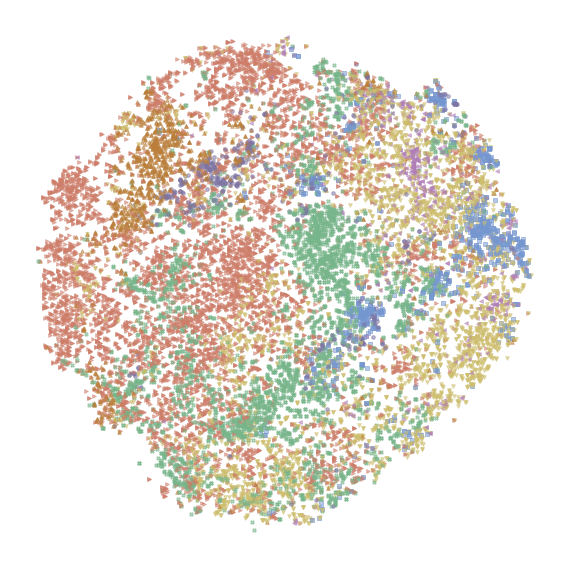

In [34]:
plot_tsne("data-driven")

## RDoC

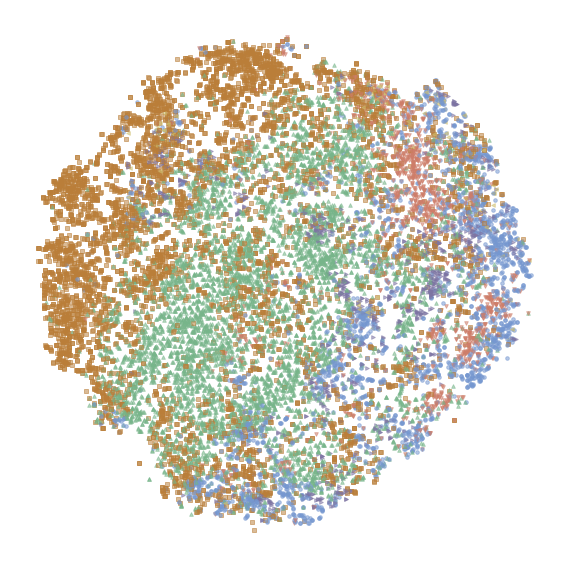

In [35]:
plot_tsne("rdoc")

## DSM

In [ ]:
plot_tsne("dsm")